In [47]:
from IPython.display import display, clear_output
import keyboard
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['cmr10'], 
    "axes.labelsize": 20, 
    "axes.titlesize": 22, 
    "xtick.labelsize": 18, 
    "ytick.labelsize": 18, 
    "legend.fontsize": 18,
    "figure.figsize": [12, 7], 
    "figure.dpi": 300 
})

$$S_{21}(\omega)=1 - \frac{\kappa_c}{i(\Omega-\omega)+\kappa+\frac{g^2}{i(\Delta E-\omega)+\gamma}}$$

In [48]:
def S_21(w, k, kc, Omega, DeltaE, gamma, g):
    up = kc
    down = 1j * (Omega - w) + k + g**2 / (1j * (DeltaE - w) + gamma)
    t = 1 - up / down
    return np.abs(t)


 # Experimental data

In [49]:
mu_b = 9.27401e-24 # J/T
h = 6.6260702e-34 # J*s
gs = 2.01928 # Obtenido de la tesis

# Los datos presentan 41 campos magnéticos distintos, con cortes de 2500 frecuencias
datos = np.loadtxt('ExpData.txt', skiprows=1)
magnetic = datos[:,0]
frequencies = datos[:,1]
transmission = datos[:,2]

# Guardamos los distintos campos magnéticos
mfield = np.unique(magnetic)
DeltaE = gs * mu_b * mfield / h * 1e-12

# Contamos el número de frecuencias 
numFrecs = len(magnetic) // len(mfield)

# Guardamos las frecuencias y transmisiones
frecs = np.zeros((len(mfield), numFrecs))
trans = np.zeros((len(mfield), numFrecs))
for i, field in enumerate(mfield):
    indices = np.where(magnetic == field)[0]
    frecs[i, :] = frequencies[indices]
    trans[i, :] = transmission[indices]  
    
#Omega = frecs[0,np.argmax(trans[0,:])]
Omega = 2.116451 # Obtenido de la tesis
gamma = 6.5e-3

print(f'Los datos experimentales presentan {len(mfield)} campos magnéticos distintos')
print(f'y cada campo tiene {numFrecs} frecuencias distintas')
print(f'\nEl valor de resonancia se da para Ω = {Omega} GHz')

Los datos experimentales presentan 41 campos magnéticos distintos
y cada campo tiene 2500 frecuencias distintas

El valor de resonancia se da para Ω = 2.116451 GHz


### Dibujamos las curvas

In [50]:
# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": "serif",
#     "font.serif": ['DejaVu Sans'],
# }) # Para visualizar LaTeX es muy lento (cuando sepa cual gráfica guaradr, se hará con latex)

# i=0
# while i<=len(mfield):
#     plt.clf()  # Limpia la figura antes de cada iteración
#     plt.plot(frecs[i,:], trans[i,:])
#     plt.title(f"B = {mfield[i]} mT")
#     plt.xlabel("Frequency (GHz)")
#     plt.ylabel('Normalized transmission')

#     plt.draw()  # Dibuja la figura actual

#     # Muestra la figura y espera a que el usuario presione Enter
#     display(plt.gcf())
#     clear_output(wait=True)
    
#     if keyboard.is_pressed('esc'):
#         break
#     elif keyboard.is_pressed('right'):
#         i += 1
#         if i >= len(mfield):
#             i = len(mfield) - 1  # Asegura que no exceda el índice máximo
#     elif keyboard.is_pressed('left'):
#         i -= 1
#         if i < 0:
#             i = 0  # Asegura que no baje del índice mínimo


# Predicciones

### Tensorflow/Keras

In [51]:
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import NonNeg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import joblib

#### Llamamos y evaluamos

In [52]:
#LLamamos al modelo
model = models.load_model("model_noNoise_acotado.keras")
# Cargar el scaler guardado
scaler_y = joblib.load('scaler_y_acotado.save')
scaler_x = RobustScaler()

trans_norm = scaler_x.fit_transform(trans)

y_pred_norm = model.predict(trans_norm)

y_pred = scaler_y.inverse_transform(y_pred_norm)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


#### Dibujamos los resultados

In [53]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ['DejaVu Sans'],
})

k_pred = y_pred[:,0]
kc_pred = y_pred[:,1]
gamma_pred = y_pred[:,2]
g_pred = y_pred[:,3]

t_values_pred = np.zeros((len(mfield), frecs.shape[1]))

for i in range (len(mfield)):
    t_values_pred[i,:] = S_21(frecs[i,:], k_pred[i], kc_pred[i], Omega, DeltaE[i], gamma_pred[i], g_pred[i])

# i = 0
# while i < len(mfield):
#     plt.clf()  # Limpia la figura antes de cada iteración
#     plt.plot(frecs[i,:], trans[i,:], color="b", marker='.', linestyle='', label="Curva real")
#     plt.plot(frecs[i,:], t_values_pred[i, :], color="r", linestyle="--", linewidth=2, label="Predicción de la red")
       
#     plt.title(f"B = {mfield[i]} mT")
#     plt.xlabel(f"Frequency (GHz)")
#     plt.ylabel(f"t ($f$)")
#     #plt.legend(framealpha=1, loc='lower right')
#     #plt.ylim(0.92, 1.01) 
#     #plt.xlim(2.085, 2.145) 

#     # Muestra los valores como un recuadro dentro de la gráfica
#     text = f"$\kappa$ pred = {k_pred[i]:.2e} GHz\n"\
#            f"$\kappa_c$ pred = {kc_pred[i]:.2e} GHz\n"\
#            f"g pred = {g_pred[i]:.2e} GHz\n"\
#            f"$\Delta$E = {DeltaE[i]:.3f} GHz"
#     plt.text(0.011, 0.3, text, transform=plt.gca().transAxes, fontsize=18, verticalalignment='top', 
#              bbox=dict(facecolor='white', alpha=1))

#     # Muestra la figura
#     display(plt.gcf())
#     clear_output(wait=True)
    
#     if keyboard.is_pressed('esc'): 
#         break
#     if keyboard.is_pressed('right'): 
#         i += 1
#     if keyboard.is_pressed('left'): 
#         i -= 1       
#         if i < 0:
#             i += 1



# Dibujos para Memoria

B = 73.5 mT ==> k = 93.2 kHz , kc = 70.6 kHz, γ = 5.0 MHz, g = 10.296 MHz
B = 74.0 mT ==> k = 134.8 kHz , kc = 67.3 kHz, γ = 14.0 MHz, g = 12.115 MHz
B = 74.5 mT ==> k = 90.9 kHz , kc = 51.7 kHz, γ = 10.1 MHz, g = 13.081 MHz
B = 75.0 mT ==> k = 1339.1 kHz , kc = 20.6 kHz, γ = 7.3 MHz, g = 14.263 MHz
B = 75.5 mT ==> k = 183.6 kHz , kc = 15.1 kHz, γ = 6.8 MHz, g = 10.921 MHz
B = 76.0 mT ==> k = 617.8 kHz , kc = 23.7 kHz, γ = 6.8 MHz, g = 11.102 MHz


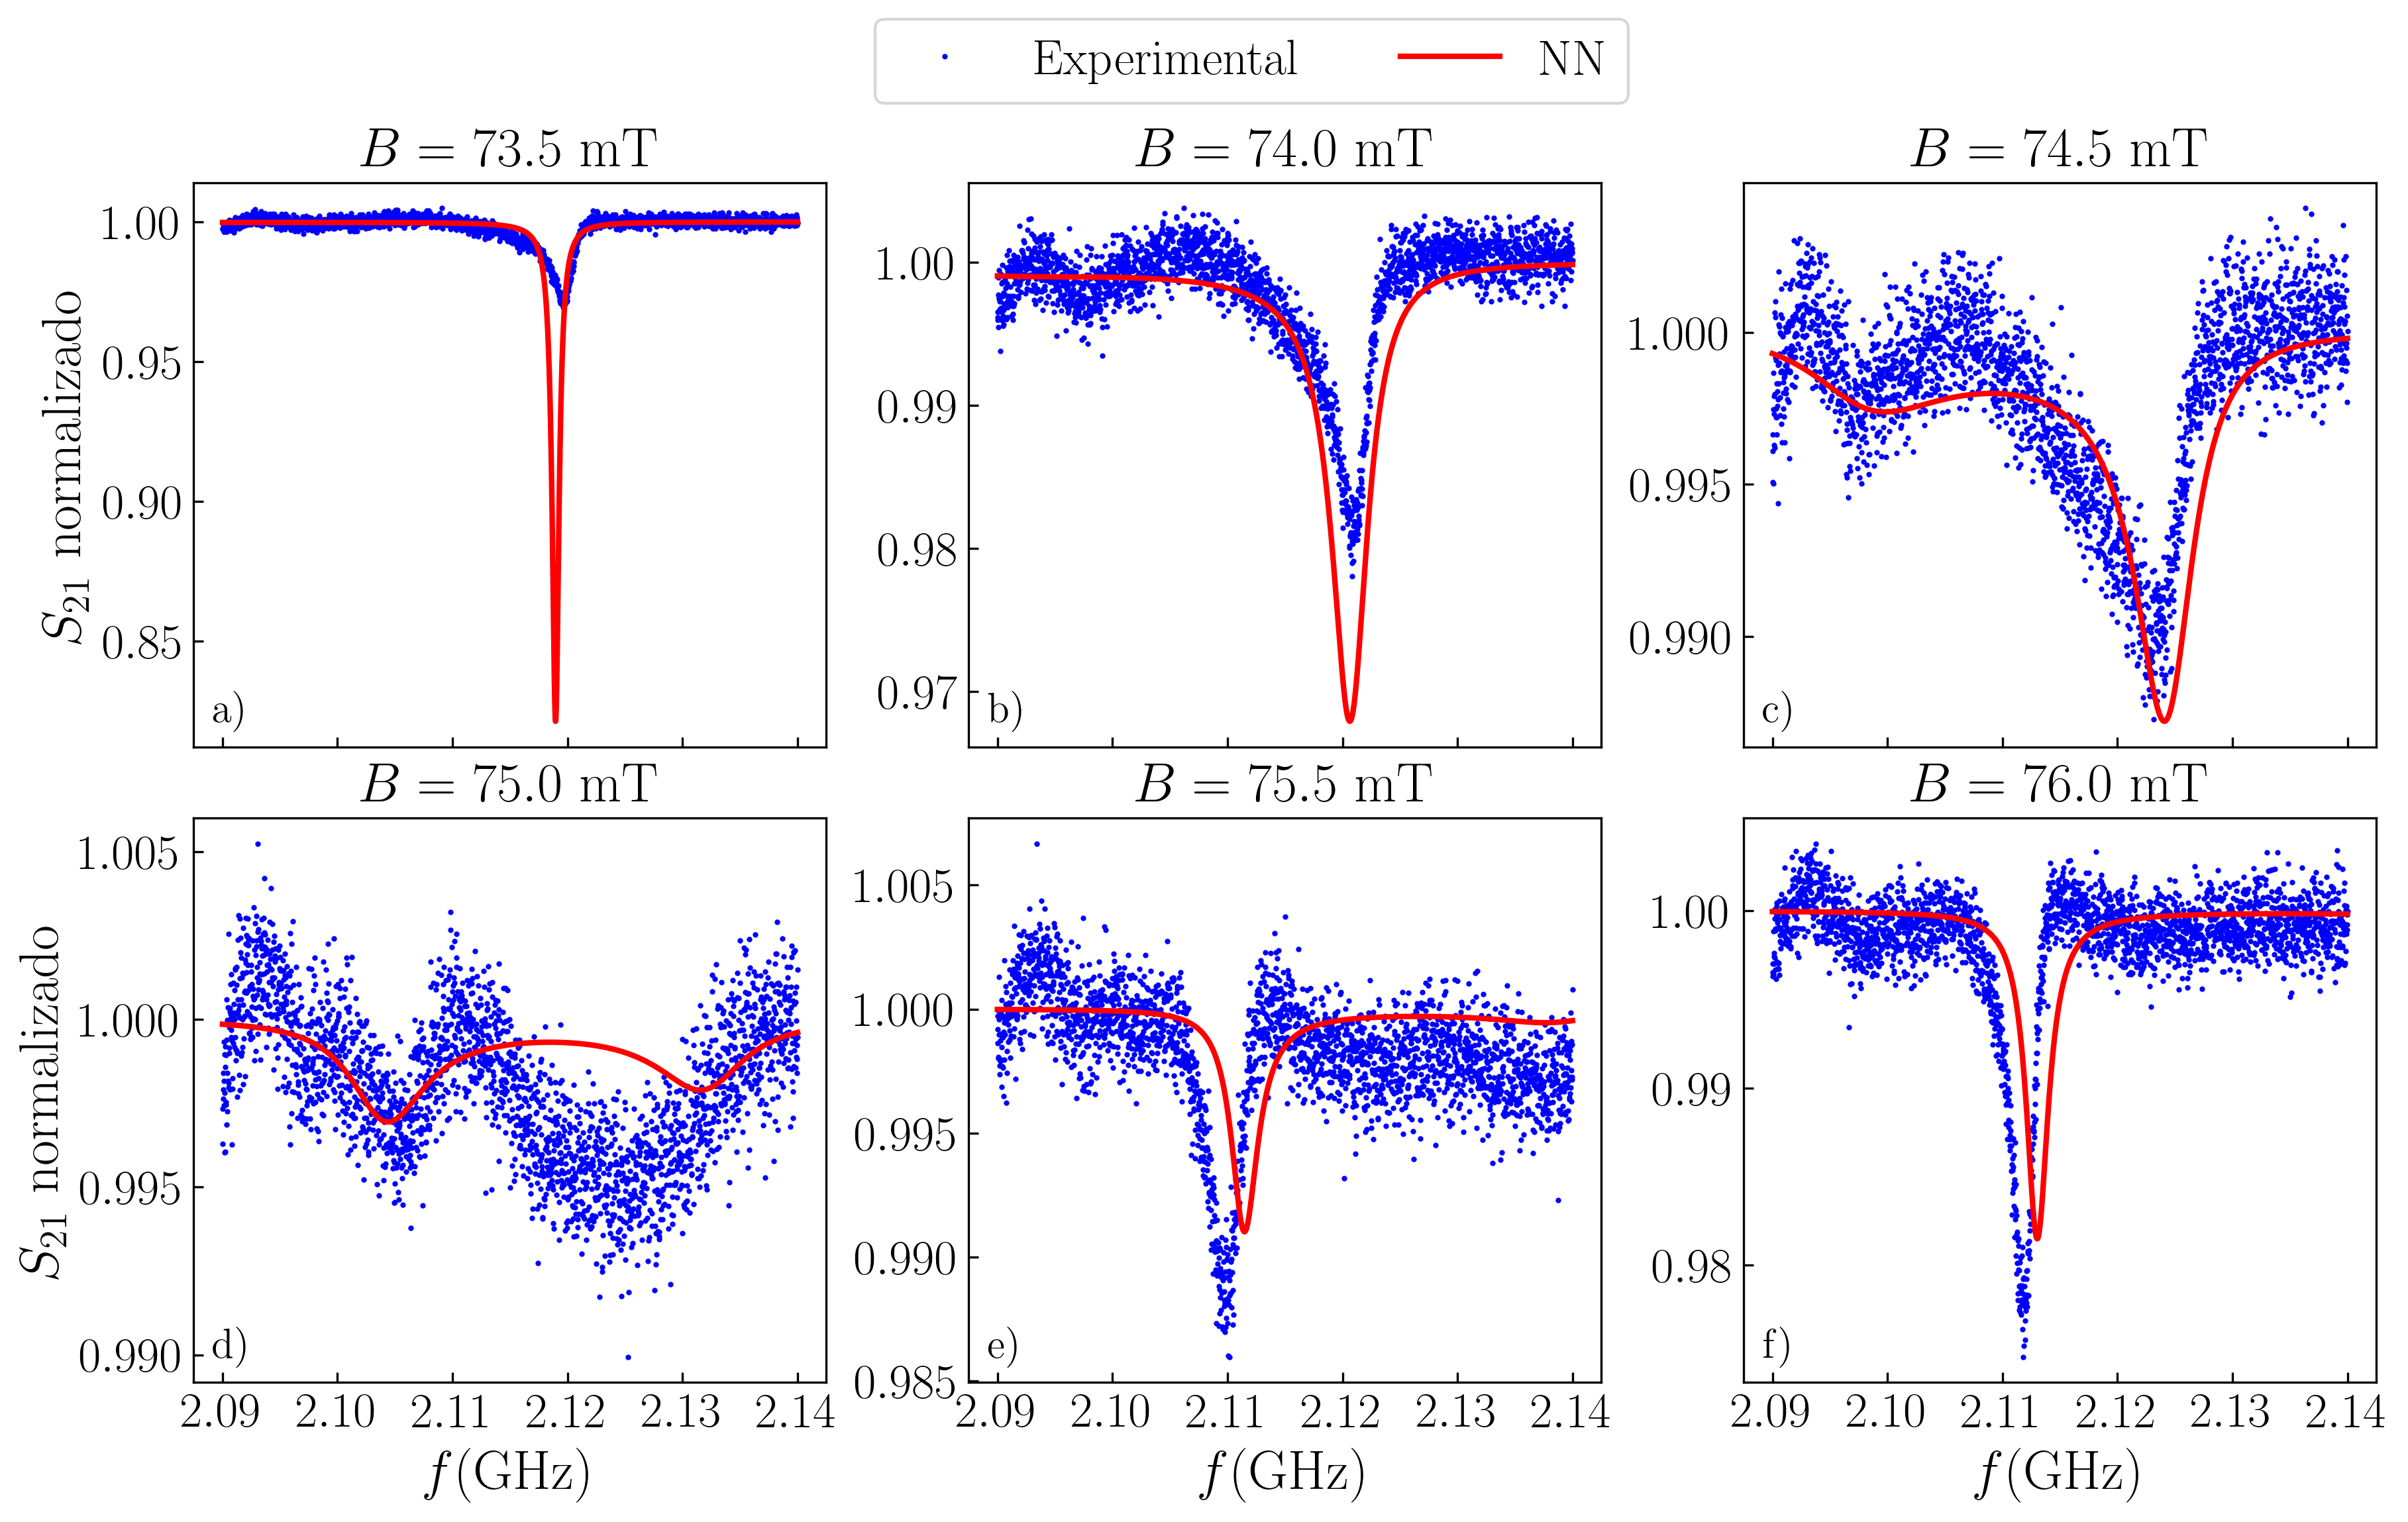


Resonancia:
k_res: 715.0 +/- 624.1 kHz
kc_res: 36.1 +/- 15.6 kHz
γ_res: 8.7 +/- 1.4 MHz
g_res: 13.672 +/- 0.591 MHz

Valor medio:
Valor medio de k: 439.8 +/- 233.6 kHz
Valor medio de kc: 38.4 +/- 19.8 kHz
Valor medio de γ: 6.8 +/- 1.5 MHz
Valor medio de g: 11.264 +/- 1.042 MHz
[2.3497325e-04 4.0878213e-04 2.7838041e-04 2.7528967e-04 2.6694505e-04
 3.8023089e-04 5.0512253e-04 3.4687298e-04 4.5516255e-04 4.3999811e-04
 4.0174910e-04 3.4050632e-04 3.0069600e-04 2.2147568e-04 9.1237322e-05
 9.1623850e-05 1.2728998e-04 9.3206225e-05 1.3481647e-04 9.0893838e-05
 1.3390754e-03 1.8359248e-04 6.1778206e-04 5.4535188e-04 5.6016672e-04
 5.7241064e-04 5.3160440e-04 5.8258569e-04 7.1177480e-04 5.5969192e-04
 5.9316942e-04 5.4951251e-04 7.8805833e-04 4.4821049e-04 5.0426042e-04
 5.5472128e-04 5.7282916e-04 5.8298581e-04 5.6991394e-04 5.8050762e-04
 5.9906580e-04]


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [55]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['cmr10'], 
    "figure.titlesize": 22,
    "axes.labelsize": 20, 
    "axes.titlesize": 20, 
    "xtick.labelsize": 18, 
    "ytick.labelsize": 18, 
    "legend.fontsize": 18,
    "figure.figsize": [12,7], 
    "figure.dpi": 300,
    "axes.formatter.use_mathtext": True
})


pics = [17,18,19,20,21,22]
labels_subplots = ["a)", "b)", "c)", "d)", "e)", "f)"]

fig, axes = plt.subplots(2, 3, constrained_layout=True)
for idx, (ax, i) in enumerate(zip(axes.flat, pics)):
    ax.plot(frecs[i,:], trans[i,:], color="b", marker='.', markersize=2, linestyle='')
    ax.plot(frecs[i,:], t_values_pred[i, :], color="r", linewidth=2)
    ax.set_xticks(np.linspace(frecs.min(), frecs.max(), 6))
    ax.set_title(f'$B={mfield[i]}$ mT')
    # ax.set_yticks(np.arange(0.96, 1.00, 0.01))
    # ax.set_ylim(0.957, 1.008)

    ax.text(0.03, 0.1, labels_subplots[idx], transform=ax.transAxes, 
        fontsize=15, fontweight='bold', va='top', ha='left')

    # Configurar etiquetas y ticks según la posición del subplot
    if idx % 3 == 0:  # Primera columna
        ax.set_ylabel(r'$S_{21}$ normalizado')  # Etiqueta y en la columna izquierda
    else:
        # ax.set_yticklabels([])  # Sin etiquetas en el eje y en la columna derecha
        ax.tick_params(axis='y', labelleft=True)

    if idx // 3 == 1:  # Última fila
        ax.set_xlabel(r'$f$(GHz)')  # Etiqueta x en la fila inferior
    else:
        ax.set_xticklabels([])  # Sin etiquetas en el eje x en la fila superior
        ax.tick_params(axis='x', labelbottom=False)

    ax.tick_params(axis='both', direction='in')

    # print(f'B={mfield[i]} mT ==> k = {k_pred[i]/1e-6:.1f} kHz , kc = {kc_pred[i]/1e-6:.1f} kHz,\
#  g = {g_pred[i]/1e-3:.3f} MHz')
    print(f'B = {mfield[i]} mT ==> k = {k_pred[i]/1e-6:.1f} kHz , kc = {kc_pred[i]/1e-6:.1f} kHz,\
 γ = {gamma_pred[i]/1e-3:.1f} MHz, g = {g_pred[i]/1e-3:.3f} MHz')


labels = ["Experimental", "NN"]
fig.legend(labels, loc='upper center', bbox_to_anchor=(0.52, 1.09), ncol=2)
plt.show()

# Calcular el valor medio de cada lista
mean_k_pred = np.mean(k_pred)
std_k_pred = np.std(k_pred)
mean_kc_pred = np.mean(kc_pred)
std_kc_pred = np.std(kc_pred)
mean_gamma_pred = np.mean(gamma_pred)
std_gamma_pred = np.std(gamma_pred)
mean_g_pred = np.mean(g_pred)
std_g_pred = np.std(g_pred)

# Mostrar los resultados valor medio
print(f"\nValor medio:\nValor medio de k: {mean_k_pred/1e-6:.1f} +/- {std_k_pred/1e-6:.1f} kHz")
print(f"Valor medio de kc: {mean_kc_pred/1e-6:.1f} +/- {std_kc_pred/1e-6:.1f} kHz")
print(f"Valor medio de γ: {mean_gamma_pred/1e-3:.1f} +/- {std_gamma_pred/1e-3:.1f} MHz")
print(f"Valor medio de g: {mean_g_pred/1e-3:.3f} +/- {std_g_pred/1e-3:.3f} MHz")
